In this notebook the eQTLs and pQTLs indentified with statistical package MatrixEQTL are analysed with respect to yeast interactome (various kinds of genetic and physical interactions, with particular emphasis on protein-protein interactions).

In [9]:
%matplotlib inline

# utilities
import gc
import time
import os

import itertools
import collections

# data analysis tools
import random
import numpy as np
import pandas as pd
from scipy import stats
from statsmodels.sandbox.stats.multicomp import multipletests

# network analysis tools
import igraph as ig

# multiprocessing tools
import subprocess
import multiprocessing as mp


# visualization tools
import matplotlib.pyplot as plt

from lib import networks
from lib import qtls
from lib import ontologies

gc.enable()

%autosave 15

Autosaving every 15 seconds


## Datasets used

Take a look at readme.md in /data folder for data description. (currently unavailable)

In [44]:
random.seed(int(time.time()))

# 112 segregants genotyped by inherited marker variants
full_genotypes_df = pd.read_table("./data/genotypes/processed_genotypes.csv")

''' Where possible, gene names were converted from systematic to standard notation '''
# mRNA expression and genotypes of strains the data is available for
eQTLs_expression_df = pd.read_table("./data/eQTLs/averaged_expression.csv")
eQTLs_genotypes_df = pd.read_table("./data/eQTLs/processed_genotypes.csv")
eQTLs_genotypes_df.drop_duplicates("SNP", inplace=True)
# Protein expression and genotypes of strains the data is available for 
pQTLs_expression_df = pd.read_table("./data/pQTLs/averaged_expression.csv")
pQTLs_genotypes_df = pd.read_table("./data/pQTLs/processed_genotypes.csv")
pQTLs_genotypes_df.drop_duplicates("SNP", inplace=True)

# pandas DataFrame —> numpy matrix = 2x speedup
pQTLs_expression_mx = \
    pQTLs_expression_df.as_matrix(
        columns=pQTLs_expression_df.columns[1:]
    )
pQTLs_genotypes_mx = \
    pQTLs_genotypes_df.as_matrix(
        columns=pQTLs_genotypes_df.columns[1:]
    )

# QTLs estimated with MatrixEQTL package for R
eQTLs_df = pd.read_table("./data/eQTLs/results.csv")
# eQTLs_df = eQTLs_df[eQTLs_df["q.value"] <= 0.05]
pQTLs_df = pd.read_table("./data/pQTLs/results.csv")
# pQTLs_df = pQTLs_df[pQTLs_df["q.value"] <= 0.05]

# Physical and genetic interactions taken from TheBioGrid project
full_interactome_df = pd.read_table("./data/interactions/yeast_interactome.csv")
# full_interactome_df = full_interactome_df[full_interactome_df['Publication year'] <= 2011]

genetic_interaction_categories = [
    "additive genetic interaction defined by inequality",
    "suppressive genetic interaction defined by inequality",
    "synthetic genetic interaction defined by inequality"
]
physical_interaction_categories = [
    "association",
    "colocalization",   
    "direct interaction",
    "physical association"
]
interaction_categories = genetic_interaction_categories + physical_interaction_categories
interactome_df = full_interactome_df.copy()
interactome_df.set_index('Interaction Type', inplace=True)
genetic_interactions_df = interactome_df[
    interactome_df.index.isin(genetic_interaction_categories)
]
physical_interactions_df = interactome_df[
    interactome_df.index.isin(physical_interaction_categories)
]

# Genetic nomenclature and mappings between different naming conventions (official lookup table)
gene_nomenclature_df = pd.read_table("./data/nomenclature/yeast_gene_nomenclature_mapping.csv")
gene_nomenclature_df.drop_duplicates("Systematic name", inplace=True)

std_to_sys = dict(zip(
    gene_nomenclature_df["Standard name"].values, 
    gene_nomenclature_df["Systematic name"].values
))
sys_to_std = {v: k for k, v in std_to_sys.items()}

# Functional modules found in PPI graph 
# according to the data published at http://thecellmap.org/costanzo2016/
functional_modules_df = pd.read_table("./data/interactions/bioprocess_annotations_costanzo2016.csv")
functional_module_types = [s.replace('/', '|') for s in np.unique(functional_modules_df["Function"].values)]

## Introduction and problem formulation

The plot below compares the distributions of eQTLs (blue) and pQTLs (yellow) in the yeast genome. Many hotspots are common, but effect sizes differ.  
**TODO:** Обозначить отрезки хромосом на оси геномных координат.

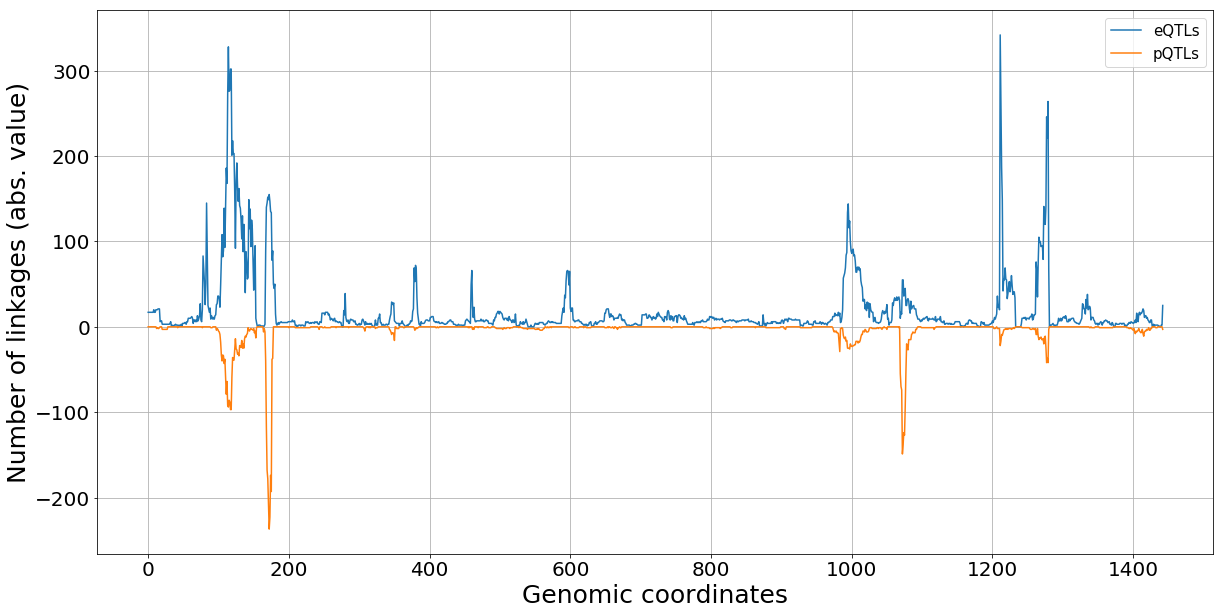

In [78]:
eQTL_y = np.array(qtls.map_linkages_to_genome_location(eQTLs_df, full_genotypes_df)[1])
pQTL_y = np.array(qtls.map_linkages_to_genome_location(pQTLs_df, full_genotypes_df)[1])

plt.figure(figsize=(20, 10))
plt.plot(eQTL_y, label="eQTLs")
plt.plot(-pQTL_y, label="pQTLs")
plt.xlabel("Genomic coordinates", fontsize=25)
plt.ylabel("Number of linkages (abs. value)", fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=15)
plt.grid()
plt.savefig("./img/linkages/eQTLs_pQTLs_combined.png")


Both eQTLs and pQTLs were computed from expression data using [MatrixEQTL](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3348564/) — a tool for R programming language.  
The same results very also previously obtained using naive approach: just take all (marker, gene) pairs, divide expression into groups by inhertied polymorphism, calculate the p-value using MWU test and do FDR-correctness with [q-value](https://github.com/StoreyLab/qvalue) package.  
Results can be viewed separately on graphs below.

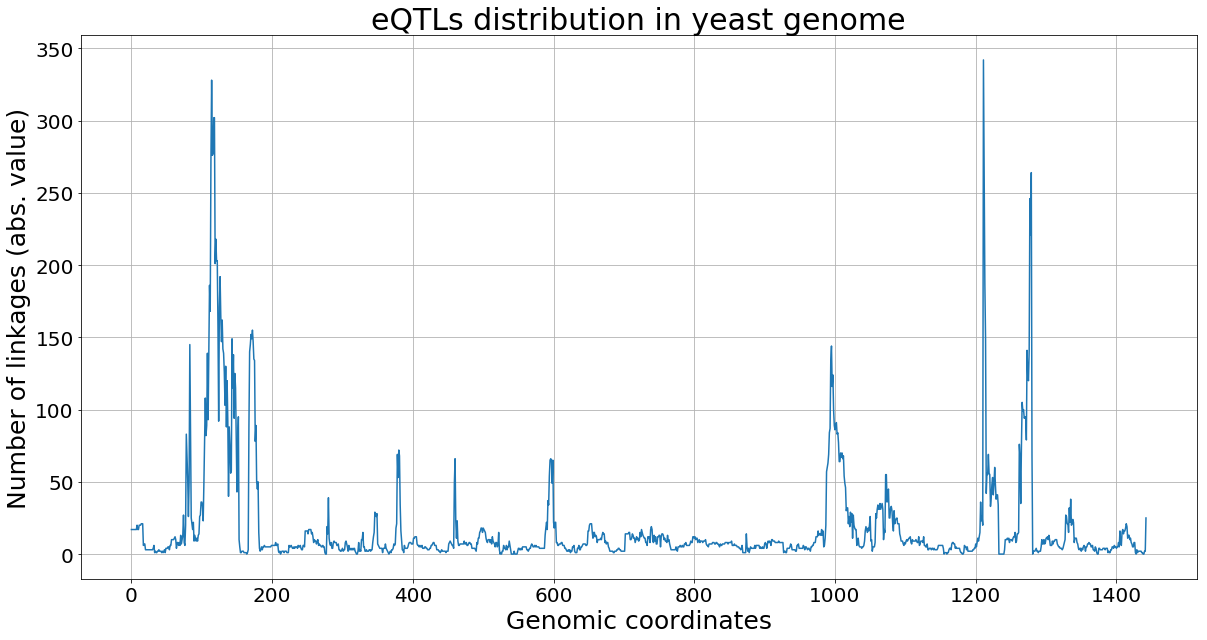

In [79]:
plt.figure(figsize=(20, 10))
plt.plot(eQTL_y)
plt.xlabel("Genomic coordinates", fontsize=25)
plt.ylabel("Number of linkages (abs. value)", fontsize=25)
plt.title("eQTLs distribution in yeast genome", fontsize=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid()
plt.show()
plt.close()

%reset_selective eQTL_y

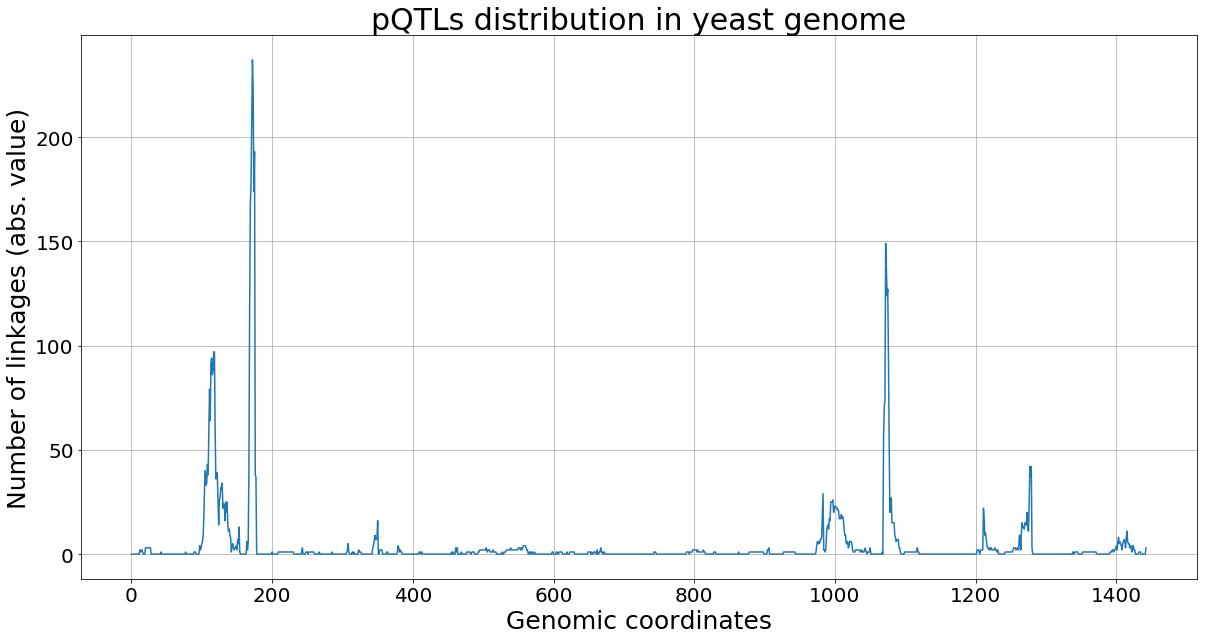

In [80]:
plt.figure(figsize=(20, 10))
plt.plot(pQTL_y)
plt.xlabel("Genomic coordinates", fontsize=25)
plt.ylabel("Number of linkages (abs. value)", fontsize=25)
plt.title("pQTLs distribution in yeast genome", fontsize=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid()
plt.show()
plt.close()

%reset_selective pQTL_y

It seems rational to suppose that transcription and translation levels must be controlled by the same genetic mechanisms.  
Unfortunately, at the first sight there is no evidence to support that intuition: sets of eQTLs and pQTLs linked to given gene show no significant overlap for almost all genes. This is illustrated by the histogram below.

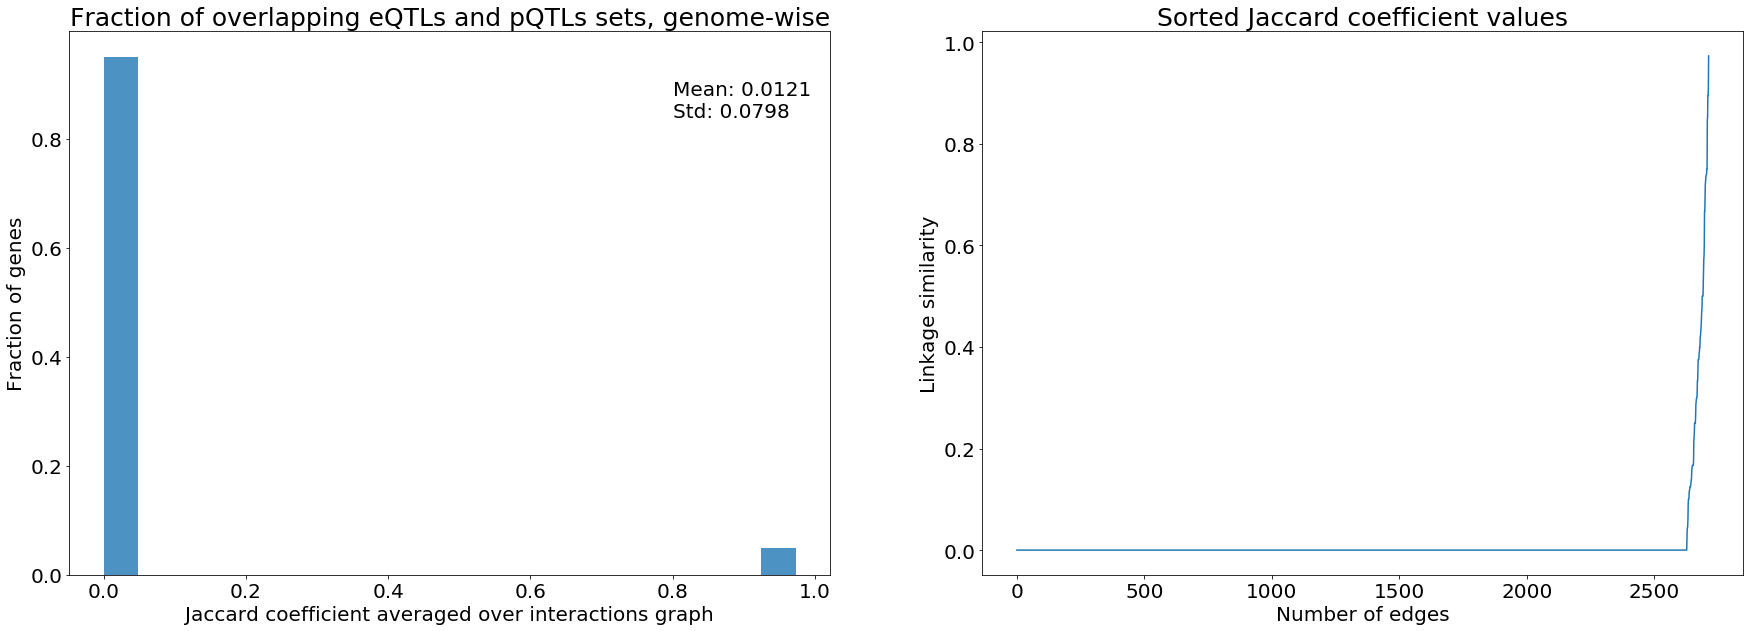

In [18]:
genes_with_linkages_of_both_types = np.unique(np.append(eQTLs_df["gene"].values, pQTLs_df["gene"].values))
linkage_overlap_data = []
for gene_name in genes_with_linkages_of_both_types:
    linked_eQTLs = set(eQTLs_df[eQTLs_df["gene"] == gene_name]["SNP"].values)
    linked_pQTLs = set(pQTLs_df[pQTLs_df["gene"] == gene_name]["SNP"].values)
    linkage_overlap_data.append(qtls.jaccard(linked_eQTLs, linked_pQTLs))
linkage_overlap_data = np.array(linkage_overlap_data)

fig = plt.figure(figsize=(30, 10))
hist_ax = fig.add_subplot(1, 2, 1)

hist, bin_edges = np.histogram(linkage_overlap_data, bins=20, density=True)
weights = np.ones_like(hist)/float(len(hist))
hist_ax.hist(hist * np.diff(bin_edges), bin_edges, weights=weights, alpha=0.8);
hist_ax.tick_params(axis='x', labelsize=20)
hist_ax.tick_params(axis='y', labelsize=20)
hist_ax.set_xlabel("Jaccard coefficient averaged over interactions graph", fontsize=20)
hist_ax.set_ylabel("Fraction of genes", fontsize=20)
hist_ax.text(
    0.8, 0.8, 
    "Mean: {0:.4f}\nStd: {1:.4f}\n".format(
        linkage_overlap_data.mean(), linkage_overlap_data.std()
    ), 
    fontsize=20
)
hist_ax.set_title("Fraction of overlapping eQTLs and pQTLs sets, genome-wise", fontsize=25);

sdata_ax = fig.add_subplot(1, 2, 2)
sdata_ax.plot(sorted(linkage_overlap_data))
sdata_ax.set_xlabel("Number of edges", fontsize=20)
sdata_ax.set_ylabel("Linkage similarity", fontsize=20)
sdata_ax.tick_params(axis='x', labelsize=20)
sdata_ax.tick_params(axis='y', labelsize=20)
sdata_ax.set_title("Sorted Jaccard coefficient values", fontsize=25)

plt.savefig("img/linkages/eQTLs_pQTLs_linkage_overlap.png", dpi=300)

%reset_selective genes_with_linkages_of_both_types|linkage_overlap_data|fig|hist|bin_edges|weights|hist_ax|sdata_ax
gc.collect();


Hypothesis arises: maybe not single genes, but functional modules tend to share linkages.  
The goal of this work is to test that hypothesis using yeast interactome data.

## Interacting genes tend to share linkage: bird's eye view.

First, it can be shown that interacting genes tend to share linkages.  
To establish that the following procedure was used:   
- Generate 1000 FDR-cutoffs in range 1e-8...1e-2
- For each threshold:
	- Select subset of significant QTLs according to given threshold
	- Divide interactions into categories and extract corresponding subgraphs
	- Perform subgraph clusterization and calculate mean Jaccard coefficient between eQTL- and pQTL-linkage sets for each cluster. Average of those is taken to be mean linkage similarity measure. No sophisticated clustering is used at the moment: each edge forms its own cluster. Nevertheless, this proves to be sufficient to show statistically significant dependence.
	- In order to ensure that observed linkage similarity is not an artefact of interactions graph structure and not its biological meaning, those graphs are randomized preserving degree sequence and analyzed in the same manner. These experiments provide strong evidence for hypothesis being tested: mean linkage similarity becomes significantly smaller. 


In [51]:
def extract_interactions(interactions_df):
    '''
    Helper function to retrieve the edges of the graph of interactions     
    '''
    return interactions_df[["Interactor A", "Interactor B"]].values

interaction_graphs_dict = {}
for category_name in interaction_categories:
    interacting_genes_df = interactome_df[interactome_df.index == category_name]
    interaction_graphs_dict[category_name] = networks.graph_from_edges(
        extract_interactions(interacting_genes_df),
    )
    
interaction_graphs_dict.update(dict(zip(["all", "genetic", "physical"],
    itertools.starmap(networks.graph_from_edges, 
        [(extract_interactions(interactome_df), False, False),
         (extract_interactions(genetic_interactions_df), False, False), 
         (extract_interactions(physical_interactions_df), False, False)]
    )))
)

In [5]:
Q_RANGE = np.logspace(-8, -2, 100)

for qtl_type, qtl_df in [("eQTLs", eQTLs_df), ("pQTLs", pQTLs_df)]:
    for interaction_type, interaction_graph in interaction_graphs_dict.items():
        interaction_graph_analyzer = qtls.FunctionalModuleAnalyzer(
            qtl_type=qtl_type,
            qtl_df=qtl_df,
            module_name=interaction_type,
            module_graph=interaction_graph,
            q_value_thresholds=Q_RANGE
        )
        interaction_graph_analyzer.analyze_robustness_of_linkage_sharing(
            title=qtl_type + " linkage similarity for " 
                  + (interaction_type if interaction_type not in ["genetic", "physical"] 
                                      else interaction_type + " interactions"),
            destination_folder="./img/linkage_sharing/thebiogrid/"
        )

%reset_selective Q_RANGE

KeyboardInterrupt: 

## Predicting pQTLs from eQTLs using PPI networks

Now, when approach using interaction networks is justified, it's time to provide solid ground: if significant fraction of pQTLs can be rediscovered from eQTLs linked to genes interacting with given (including itself), it will serve as an additional evidence for hypothesis being actually true (once again, no sophisticated clustering was performed here, while it would possibly yield better results).  

The main idea is not to test all (marker, gene) pairs but to filter for trusted only. In order to get rid of the pairs that will not link (or at least to dump more false than real linkages), the following approach is proposed: 
1. For each gene with measured protein abundance select its eQTL linkages as candidates into pQTLs. 
2. Extend eQTL linkages with those of the interacting genes. 

As a result, FDR decreases for the same q-value threshold, which results in more trustworthy results.

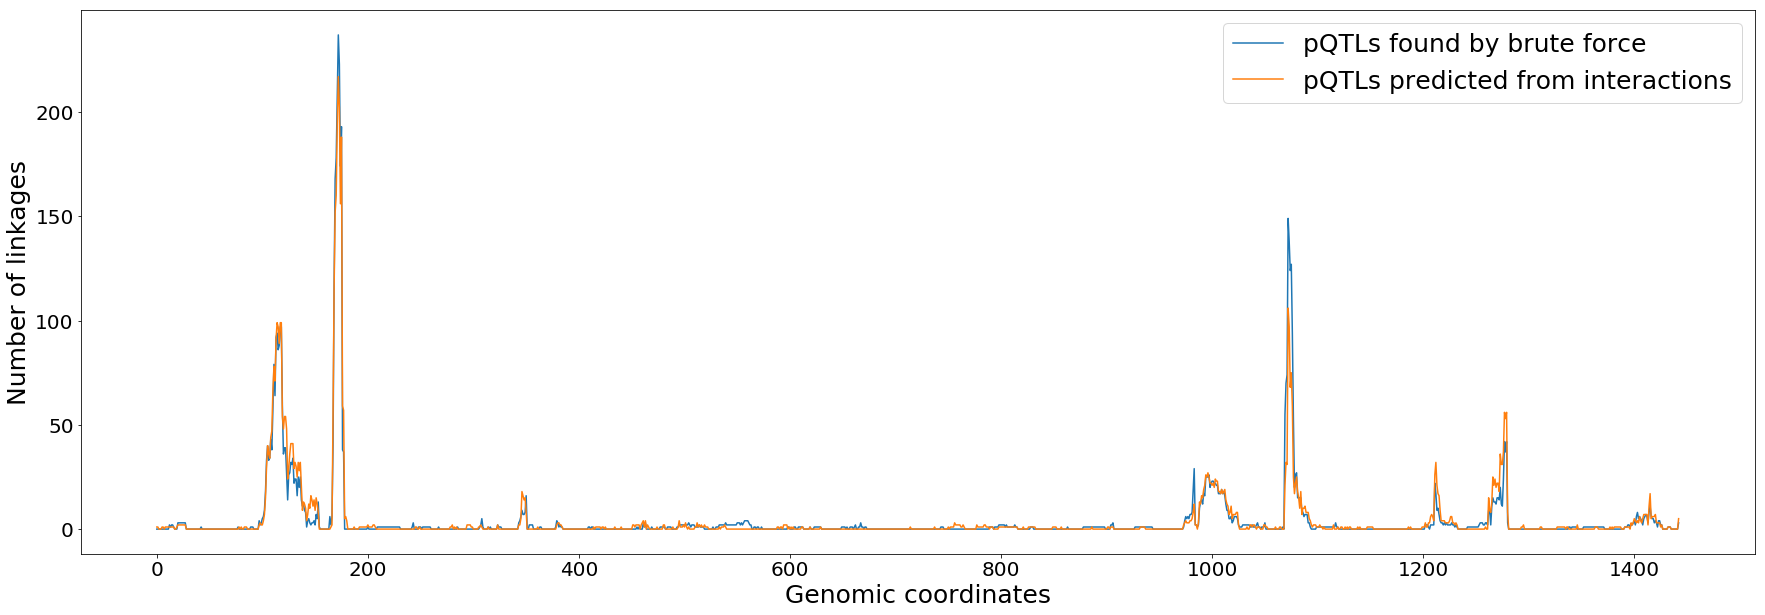

In [7]:
pqtl_finder = qtls.PqtlPredictor(
    eQTLs_df, pQTLs_df,
    eQTLs_expression_df, eQTLs_genotypes_df,
    pQTLs_expression_df, pQTLs_genotypes_df,
    full_genotypes_df,
    "full interactome",
    networks.graph_from_edges(extract_interactions(interactome_df))
)

results = pqtl_finder.predict()

%reset_selective pqtl_finder

Here is some statistics computed from different subgraphs of interactome. 

**Physical interactions only**:   
- Common linkages: 2021, 32.7977929243752%
- Old linkages, total: 6162
- New linkages, total: 4048
- New linkages found: 2027

**Physical and genetic interactions**:  
- Common linkages: 3695, 59.96429730606946%
- Old linkages, total: 6162
- New linkages, total: 6124
- New linkages found: 2429

**Full interactome**:
- Common linkages: 3688, 59.85069782538137%
- Old linkages, total: 6162
- New linkages, total: 6219
- New linkages found: 2531

It becomes evident, that a significant fraction of estimated pQTLs can be reproduced using proposed approach.  
**Nevertheless, many questions arise**:
- Which fraction of trans-pQTLs is reproduced? (and is this approach capable of detecting those)
- Are all the hotspots reproduced? If some are not, why then? It is worth mentioning, that some of those were given cryptic names which are nowhere to be found. 
- How robust the results are? So far results are not compared with those computed from simulated, perturbed graphs. 

## Interacting genes tend to share linkages: analysis of coarse-grained functional modules

The problem is, interaction types given in the BioGrid database are too general from the biological viewpoint.  
It's worth investigating in more detail, which biological processes demonstrate statistically significant link between regulation mechanisms of different types of expression.  
In order to do so, curated functional modules taken from the ["Global Genetic Interaction Dataset"](http://thecellmap.org/costanzo2016) (University of Toronto) are tested, among those:
- Cell polarity & morphogenesis
- Cytokinesis
- DNA replication & repair
- Glycosylation, protein folding|targeting, cell wall biosynthesis
- MVB sorting and pH depending signaling
- Metabolism
- Mitosis & chromosome segregation
- Nuclear-cytoplasmic transport
- Peroxisome
- Protein degradation|turnover
- Respiration, oxidative phosphorylation, mitochondrial targeting
- Ribosome biogenesis
- Transcription & chromatin organization
- Vesicle traffic
- mRNA & tRNA processing
- rDNA & ncDNA processing
- tRNA wobble modification

In [47]:
functional_modules_dict = {}
for module_type in functional_module_types:
    functional_modules_dict[module_type] = functional_modules_df[
        functional_modules_df["Function"].str.contains(module_type)
    ]["Interactor (std)"].values

In [53]:
Q_RANGE = np.logspace(-8, -2, 100)

for interaction_type in ["all", "genetic", "physical"]:
    interactome_graph = interaction_graphs_dict[interaction_type]
    for qtl_type, qtl_df in [("eQTLs", eQTLs_df), ("pQTLs", pQTLs_df)]:
        for module_name in functional_modules_dict.keys():
            module_graph = interactome_graph.subgraph(
                set(functional_modules_dict[module_name])
                & set(interactome_graph.vs["name"])
            ).simplify()
            module_graph.vs.select(_degree=0).delete()
            if module_graph.vcount() == 0:
                print("{} — no data!", module_name)
                continue
            
            module_graph_analyzer = qtls.FunctionalModuleAnalyzer(
                qtl_type=qtl_type,
                qtl_df=qtl_df,
                module_name=module_name,
                module_graph=module_graph,
                q_value_thresholds=Q_RANGE
            )
    
            module_graph_analyzer.analyze_robustness_of_linkage_sharing(
                title="eQTLs" + " linkage similarity for " + module_name + " functional module",
                destination_folder="./img/linkage_sharing/thecellmap/" + interaction_type + "_interactions/"
            )

gc.collect()
%reset_selective interactome_graph

/home/vvi/Science/eQTL_analysis/lib/qtls.py:226: RuntimeWarning: Cannot shuffle graph, maybe there is only a single one? at gengraph_graph_molloy_hash.cpp:332
  method="vl"


/home/vvi/Science/eQTL_analysis/lib/qtls.py:226: RuntimeWarning: Cannot shuffle graph, maybe there is only a single one? at gengraph_graph_molloy_hash.cpp:332
  method="vl"


/home/vvi/Science/eQTL_analysis/lib/qtls.py:226: RuntimeWarning: Cannot shuffle graph, maybe there is only a single one? at gengraph_graph_molloy_hash.cpp:332
  method="vl"


/home/vvi/Science/eQTL_analysis/lib/qtls.py:226: RuntimeWarning: Cannot shuffle graph, maybe there is only a single one? at gengraph_graph_molloy_hash.cpp:332
  method="vl"


/home/vvi/Science/eQTL_analysis/lib/qtls.py:226: RuntimeWarning: Cannot shuffle graph, maybe there is only a single one? at gengraph_graph_molloy_hash.cpp:332
  method="vl"


/home/vvi/Science/eQTL_analysis/lib/qtls.py:226: RuntimeWarning: Cannot shuffle graph, maybe there is only a single one? at gengraph_graph_molloy_hash.cpp:332
  method="vl"


/home/vvi/Science/eQTL_analysis/lib/qtls.py:226: RuntimeWarning: Cannot shuffle graph, maybe there is only a single one? at gengraph_graph_molloy_hash.cpp:332
  method="vl"


/home/vvi/Science/eQTL_analysis/lib/qtls.py:226: RuntimeWarning: Cannot shuffle graph, maybe there is only a single one? at gengraph_graph_molloy_hash.cpp:332
  method="vl"


/home/vvi/anaconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1910: RuntimeWarning: invalid value encountered in multiply
  lower_bound = self.a * scale + loc
/home/vvi/anaconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1911: RuntimeWarning: invalid value encountered in multiply
  upper_bound = self.b * scale + loc


/home/vvi/Science/eQTL_analysis/lib/qtls.py:226: RuntimeWarning: Cannot shuffle graph, maybe there is only a single one? at gengraph_graph_molloy_hash.cpp:332
  method="vl"


/home/vvi/Science/eQTL_analysis/lib/qtls.py:226: RuntimeWarning: Cannot shuffle graph, maybe there is only a single one? at gengraph_graph_molloy_hash.cpp:332
  method="vl"


/home/vvi/Science/eQTL_analysis/lib/qtls.py:226: RuntimeWarning: Cannot shuffle graph, maybe there is only a single one? at gengraph_graph_molloy_hash.cpp:332
  method="vl"


/home/vvi/Science/eQTL_analysis/lib/qtls.py:226: RuntimeWarning: Cannot shuffle graph, maybe there is only a single one? at gengraph_graph_molloy_hash.cpp:332
  method="vl"


/home/vvi/Science/eQTL_analysis/lib/qtls.py:226: RuntimeWarning: Cannot shuffle graph, maybe there is only a single one? at gengraph_graph_molloy_hash.cpp:332
  method="vl"


/home/vvi/Science/eQTL_analysis/lib/qtls.py:226: RuntimeWarning: Cannot shuffle graph, maybe there is only a single one? at gengraph_graph_molloy_hash.cpp:332
  method="vl"


/home/vvi/Science/eQTL_analysis/lib/qtls.py:226: RuntimeWarning: Cannot shuffle graph, maybe there is only a single one? at gengraph_graph_molloy_hash.cpp:332
  method="vl"


/home/vvi/Science/eQTL_analysis/lib/qtls.py:226: RuntimeWarning: Cannot shuffle graph, maybe there is only a single one? at gengraph_graph_molloy_hash.cpp:332
  method="vl"


/home/vvi/Science/eQTL_analysis/lib/qtls.py:226: RuntimeWarning: Cannot shuffle graph, maybe there is only a single one? at gengraph_graph_molloy_hash.cpp:332
  method="vl"


/home/vvi/Science/eQTL_analysis/lib/qtls.py:226: RuntimeWarning: Cannot shuffle graph, maybe there is only a single one? at gengraph_graph_molloy_hash.cpp:332
  method="vl"


/home/vvi/Science/eQTL_analysis/lib/qtls.py:226: RuntimeWarning: Cannot shuffle graph, maybe there is only a single one? at gengraph_graph_molloy_hash.cpp:332
  method="vl"


/home/vvi/Science/eQTL_analysis/lib/qtls.py:226: RuntimeWarning: Cannot shuffle graph, maybe there is only a single one? at gengraph_graph_molloy_hash.cpp:332
  method="vl"


/home/vvi/Science/eQTL_analysis/lib/qtls.py:226: RuntimeWarning: Cannot shuffle graph, maybe there is only a single one? at gengraph_graph_molloy_hash.cpp:332
  method="vl"


/home/vvi/Science/eQTL_analysis/lib/qtls.py:226: RuntimeWarning: Cannot shuffle graph, maybe there is only a single one? at gengraph_graph_molloy_hash.cpp:332
  method="vl"


/home/vvi/Science/eQTL_analysis/lib/qtls.py:226: RuntimeWarning: Cannot shuffle graph, maybe there is only a single one? at gengraph_graph_molloy_hash.cpp:332
  method="vl"


/home/vvi/Science/eQTL_analysis/lib/qtls.py:226: RuntimeWarning: Cannot shuffle graph, maybe there is only a single one? at gengraph_graph_molloy_hash.cpp:332
  method="vl"


/home/vvi/Science/eQTL_analysis/lib/qtls.py:226: RuntimeWarning: Cannot shuffle graph, maybe there is only a single one? at gengraph_graph_molloy_hash.cpp:332
  method="vl"


/home/vvi/Science/eQTL_analysis/lib/qtls.py:226: RuntimeWarning: Cannot shuffle graph, maybe there is only a single one? at gengraph_graph_molloy_hash.cpp:332
  method="vl"


/home/vvi/Science/eQTL_analysis/lib/qtls.py:226: RuntimeWarning: Cannot shuffle graph, maybe there is only a single one? at gengraph_graph_molloy_hash.cpp:332
  method="vl"


/home/vvi/Science/eQTL_analysis/lib/qtls.py:226: RuntimeWarning: Cannot shuffle graph, maybe there is only a single one? at gengraph_graph_molloy_hash.cpp:332
  method="vl"


/home/vvi/Science/eQTL_analysis/lib/qtls.py:226: RuntimeWarning: Cannot shuffle graph, maybe there is only a single one? at gengraph_graph_molloy_hash.cpp:332
  method="vl"


/home/vvi/Science/eQTL_analysis/lib/qtls.py:226: RuntimeWarning: Cannot shuffle graph, maybe there is only a single one? at gengraph_graph_molloy_hash.cpp:332
  method="vl"


/home/vvi/Science/eQTL_analysis/lib/qtls.py:226: RuntimeWarning: Cannot shuffle graph, maybe there is only a single one? at gengraph_graph_molloy_hash.cpp:332
  method="vl"


/home/vvi/Science/eQTL_analysis/lib/qtls.py:226: RuntimeWarning: Cannot shuffle graph, maybe there is only a single one? at gengraph_graph_molloy_hash.cpp:332
  method="vl"


/home/vvi/Science/eQTL_analysis/lib/qtls.py:226: RuntimeWarning: Cannot shuffle graph, maybe there is only a single one? at gengraph_graph_molloy_hash.cpp:332
  method="vl"


/home/vvi/Science/eQTL_analysis/lib/qtls.py:226: RuntimeWarning: Cannot shuffle graph, maybe there is only a single one? at gengraph_graph_molloy_hash.cpp:332
  method="vl"


/home/vvi/Science/eQTL_analysis/lib/qtls.py:226: RuntimeWarning: Cannot shuffle graph, maybe there is only a single one? at gengraph_graph_molloy_hash.cpp:332
  method="vl"


/home/vvi/Science/eQTL_analysis/lib/qtls.py:226: RuntimeWarning: Cannot shuffle graph, maybe there is only a single one? at gengraph_graph_molloy_hash.cpp:332
  method="vl"


/home/vvi/Science/eQTL_analysis/lib/qtls.py:226: RuntimeWarning: Cannot shuffle graph, maybe there is only a single one? at gengraph_graph_molloy_hash.cpp:332
  method="vl"


/home/vvi/Science/eQTL_analysis/lib/qtls.py:226: RuntimeWarning: Cannot shuffle graph, maybe there is only a single one? at gengraph_graph_molloy_hash.cpp:332
  method="vl"


/home/vvi/Science/eQTL_analysis/lib/qtls.py:226: RuntimeWarning: Cannot shuffle graph, maybe there is only a single one? at gengraph_graph_molloy_hash.cpp:332
  method="vl"


/home/vvi/Science/eQTL_analysis/lib/qtls.py:226: RuntimeWarning: Cannot shuffle graph, maybe there is only a single one? at gengraph_graph_molloy_hash.cpp:332
  method="vl"


/home/vvi/Science/eQTL_analysis/lib/qtls.py:226: RuntimeWarning: Cannot shuffle graph, maybe there is only a single one? at gengraph_graph_molloy_hash.cpp:332
  method="vl"


/home/vvi/Science/eQTL_analysis/lib/qtls.py:226: RuntimeWarning: Cannot shuffle graph, maybe there is only a single one? at gengraph_graph_molloy_hash.cpp:332
  method="vl"


/home/vvi/Science/eQTL_analysis/lib/qtls.py:226: RuntimeWarning: Cannot shuffle graph, maybe there is only a single one? at gengraph_graph_molloy_hash.cpp:332
  method="vl"


/home/vvi/Science/eQTL_analysis/lib/qtls.py:226: RuntimeWarning: Cannot shuffle graph, maybe there is only a single one? at gengraph_graph_molloy_hash.cpp:332
  method="vl"


/home/vvi/Science/eQTL_analysis/lib/qtls.py:226: RuntimeWarning: Cannot shuffle graph, maybe there is only a single one? at gengraph_graph_molloy_hash.cpp:332
  method="vl"


/home/vvi/Science/eQTL_analysis/lib/qtls.py:226: RuntimeWarning: Cannot shuffle graph, maybe there is only a single one? at gengraph_graph_molloy_hash.cpp:332
  method="vl"


/home/vvi/Science/eQTL_analysis/lib/qtls.py:226: RuntimeWarning: Cannot shuffle graph, maybe there is only a single one? at gengraph_graph_molloy_hash.cpp:332
  method="vl"


/home/vvi/Science/eQTL_analysis/lib/qtls.py:226: RuntimeWarning: Cannot shuffle graph, maybe there is only a single one? at gengraph_graph_molloy_hash.cpp:332
  method="vl"


/home/vvi/Science/eQTL_analysis/lib/qtls.py:226: RuntimeWarning: Cannot shuffle graph, maybe there is only a single one? at gengraph_graph_molloy_hash.cpp:332
  method="vl"


/home/vvi/Science/eQTL_analysis/lib/qtls.py:226: RuntimeWarning: Cannot shuffle graph, maybe there is only a single one? at gengraph_graph_molloy_hash.cpp:332
  method="vl"


/home/vvi/Science/eQTL_analysis/lib/qtls.py:226: RuntimeWarning: Cannot shuffle graph, maybe there is only a single one? at gengraph_graph_molloy_hash.cpp:332
  method="vl"


/home/vvi/Science/eQTL_analysis/lib/qtls.py:226: RuntimeWarning: Cannot shuffle graph, maybe there is only a single one? at gengraph_graph_molloy_hash.cpp:332
  method="vl"


/home/vvi/Science/eQTL_analysis/lib/qtls.py:226: RuntimeWarning: Cannot shuffle graph, maybe there is only a single one? at gengraph_graph_molloy_hash.cpp:332
  method="vl"


/home/vvi/Science/eQTL_analysis/lib/qtls.py:226: RuntimeWarning: Cannot shuffle graph, maybe there is only a single one? at gengraph_graph_molloy_hash.cpp:332
  method="vl"


/home/vvi/Science/eQTL_analysis/lib/qtls.py:226: RuntimeWarning: Cannot shuffle graph, maybe there is only a single one? at gengraph_graph_molloy_hash.cpp:332
  method="vl"


/home/vvi/Science/eQTL_analysis/lib/qtls.py:226: RuntimeWarning: Cannot shuffle graph, maybe there is only a single one? at gengraph_graph_molloy_hash.cpp:332
  method="vl"


/home/vvi/Science/eQTL_analysis/lib/qtls.py:226: RuntimeWarning: Cannot shuffle graph, maybe there is only a single one? at gengraph_graph_molloy_hash.cpp:332
  method="vl"


/home/vvi/Science/eQTL_analysis/lib/qtls.py:226: RuntimeWarning: Cannot shuffle graph, maybe there is only a single one? at gengraph_graph_molloy_hash.cpp:332
  method="vl"


/home/vvi/Science/eQTL_analysis/lib/qtls.py:226: RuntimeWarning: Cannot shuffle graph, maybe there is only a single one? at gengraph_graph_molloy_hash.cpp:332
  method="vl"


/home/vvi/Science/eQTL_analysis/lib/qtls.py:226: RuntimeWarning: Cannot shuffle graph, maybe there is only a single one? at gengraph_graph_molloy_hash.cpp:332
  method="vl"


/home/vvi/Science/eQTL_analysis/lib/qtls.py:226: RuntimeWarning: Cannot shuffle graph, maybe there is only a single one? at gengraph_graph_molloy_hash.cpp:332
  method="vl"


/home/vvi/Science/eQTL_analysis/lib/qtls.py:226: RuntimeWarning: Cannot shuffle graph, maybe there is only a single one? at gengraph_graph_molloy_hash.cpp:332
  method="vl"


/home/vvi/Science/eQTL_analysis/lib/qtls.py:226: RuntimeWarning: Cannot shuffle graph, maybe there is only a single one? at gengraph_graph_molloy_hash.cpp:332
  method="vl"


/home/vvi/Science/eQTL_analysis/lib/qtls.py:226: RuntimeWarning: Cannot shuffle graph, maybe there is only a single one? at gengraph_graph_molloy_hash.cpp:332
  method="vl"


/home/vvi/Science/eQTL_analysis/lib/qtls.py:226: RuntimeWarning: Cannot shuffle graph, maybe there is only a single one? at gengraph_graph_molloy_hash.cpp:332
  method="vl"


/home/vvi/Science/eQTL_analysis/lib/qtls.py:226: RuntimeWarning: Cannot shuffle graph, maybe there is only a single one? at gengraph_graph_molloy_hash.cpp:332
  method="vl"


/home/vvi/Science/eQTL_analysis/lib/qtls.py:226: RuntimeWarning: Cannot shuffle graph, maybe there is only a single one? at gengraph_graph_molloy_hash.cpp:332
  method="vl"


/home/vvi/Science/eQTL_analysis/lib/qtls.py:226: RuntimeWarning: Cannot shuffle graph, maybe there is only a single one? at gengraph_graph_molloy_hash.cpp:332
  method="vl"


/home/vvi/Science/eQTL_analysis/lib/qtls.py:226: RuntimeWarning: Cannot shuffle graph, maybe there is only a single one? at gengraph_graph_molloy_hash.cpp:332
  method="vl"


/home/vvi/Science/eQTL_analysis/lib/qtls.py:226: RuntimeWarning: Cannot shuffle graph, maybe there is only a single one? at gengraph_graph_molloy_hash.cpp:332
  method="vl"


/home/vvi/Science/eQTL_analysis/lib/qtls.py:226: RuntimeWarning: Cannot shuffle graph, maybe there is only a single one? at gengraph_graph_molloy_hash.cpp:332
  method="vl"


/home/vvi/Science/eQTL_analysis/lib/qtls.py:226: RuntimeWarning: Cannot shuffle graph, maybe there is only a single one? at gengraph_graph_molloy_hash.cpp:332
  method="vl"


/home/vvi/Science/eQTL_analysis/lib/qtls.py:226: RuntimeWarning: Cannot shuffle graph, maybe there is only a single one? at gengraph_graph_molloy_hash.cpp:332
  method="vl"


/home/vvi/Science/eQTL_analysis/lib/qtls.py:226: RuntimeWarning: Cannot shuffle graph, maybe there is only a single one? at gengraph_graph_molloy_hash.cpp:332
  method="vl"


/home/vvi/Science/eQTL_analysis/lib/qtls.py:226: RuntimeWarning: Cannot shuffle graph, maybe there is only a single one? at gengraph_graph_molloy_hash.cpp:332
  method="vl"


/home/vvi/Science/eQTL_analysis/lib/qtls.py:226: RuntimeWarning: Cannot shuffle graph, maybe there is only a single one? at gengraph_graph_molloy_hash.cpp:332
  method="vl"


/home/vvi/Science/eQTL_analysis/lib/qtls.py:226: RuntimeWarning: Cannot shuffle graph, maybe there is only a single one? at gengraph_graph_molloy_hash.cpp:332
  method="vl"


/home/vvi/Science/eQTL_analysis/lib/qtls.py:226: RuntimeWarning: Cannot shuffle graph, maybe there is only a single one? at gengraph_graph_molloy_hash.cpp:332
  method="vl"


/home/vvi/Science/eQTL_analysis/lib/qtls.py:226: RuntimeWarning: Cannot shuffle graph, maybe there is only a single one? at gengraph_graph_molloy_hash.cpp:332
  method="vl"


/home/vvi/Science/eQTL_analysis/lib/qtls.py:226: RuntimeWarning: Cannot shuffle graph, maybe there is only a single one? at gengraph_graph_molloy_hash.cpp:332
  method="vl"


/home/vvi/Science/eQTL_analysis/lib/qtls.py:226: RuntimeWarning: Cannot shuffle graph, maybe there is only a single one? at gengraph_graph_molloy_hash.cpp:332
  method="vl"


/home/vvi/Science/eQTL_analysis/lib/qtls.py:226: RuntimeWarning: Cannot shuffle graph, maybe there is only a single one? at gengraph_graph_molloy_hash.cpp:332
  method="vl"


/home/vvi/Science/eQTL_analysis/lib/qtls.py:226: RuntimeWarning: Cannot shuffle graph, maybe there is only a single one? at gengraph_graph_molloy_hash.cpp:332
  method="vl"


/home/vvi/Science/eQTL_analysis/lib/qtls.py:226: RuntimeWarning: Cannot shuffle graph, maybe there is only a single one? at gengraph_graph_molloy_hash.cpp:332
  method="vl"


/home/vvi/Science/eQTL_analysis/lib/qtls.py:226: RuntimeWarning: Cannot shuffle graph, maybe there is only a single one? at gengraph_graph_molloy_hash.cpp:332
  method="vl"


/home/vvi/Science/eQTL_analysis/lib/qtls.py:226: RuntimeWarning: Cannot shuffle graph, maybe there is only a single one? at gengraph_graph_molloy_hash.cpp:332
  method="vl"


/home/vvi/Science/eQTL_analysis/lib/qtls.py:226: RuntimeWarning: Cannot shuffle graph, maybe there is only a single one? at gengraph_graph_molloy_hash.cpp:332
  method="vl"


/home/vvi/Science/eQTL_analysis/lib/qtls.py:226: RuntimeWarning: Cannot shuffle graph, maybe there is only a single one? at gengraph_graph_molloy_hash.cpp:332
  method="vl"


/home/vvi/Science/eQTL_analysis/lib/qtls.py:226: RuntimeWarning: Cannot shuffle graph, maybe there is only a single one? at gengraph_graph_molloy_hash.cpp:332
  method="vl"


/home/vvi/Science/eQTL_analysis/lib/qtls.py:226: RuntimeWarning: Cannot shuffle graph, maybe there is only a single one? at gengraph_graph_molloy_hash.cpp:332
  method="vl"


/home/vvi/Science/eQTL_analysis/lib/qtls.py:226: RuntimeWarning: Cannot shuffle graph, maybe there is only a single one? at gengraph_graph_molloy_hash.cpp:332
  method="vl"


/home/vvi/Science/eQTL_analysis/lib/qtls.py:226: RuntimeWarning: Cannot shuffle graph, maybe there is only a single one? at gengraph_graph_molloy_hash.cpp:332
  method="vl"


/home/vvi/Science/eQTL_analysis/lib/qtls.py:226: RuntimeWarning: Cannot shuffle graph, maybe there is only a single one? at gengraph_graph_molloy_hash.cpp:332
  method="vl"


/home/vvi/Science/eQTL_analysis/lib/qtls.py:226: RuntimeWarning: Cannot shuffle graph, maybe there is only a single one? at gengraph_graph_molloy_hash.cpp:332
  method="vl"


/home/vvi/Science/eQTL_analysis/lib/qtls.py:226: RuntimeWarning: Cannot shuffle graph, maybe there is only a single one? at gengraph_graph_molloy_hash.cpp:332
  method="vl"


/home/vvi/Science/eQTL_analysis/lib/qtls.py:226: RuntimeWarning: Cannot shuffle graph, maybe there is only a single one? at gengraph_graph_molloy_hash.cpp:332
  method="vl"


/home/vvi/Science/eQTL_analysis/lib/qtls.py:226: RuntimeWarning: Cannot shuffle graph, maybe there is only a single one? at gengraph_graph_molloy_hash.cpp:332
  method="vl"


/home/vvi/Science/eQTL_analysis/lib/qtls.py:226: RuntimeWarning: Cannot shuffle graph, maybe there is only a single one? at gengraph_graph_molloy_hash.cpp:332
  method="vl"


/home/vvi/Science/eQTL_analysis/lib/qtls.py:226: RuntimeWarning: Cannot shuffle graph, maybe there is only a single one? at gengraph_graph_molloy_hash.cpp:332
  method="vl"


/home/vvi/Science/eQTL_analysis/lib/qtls.py:226: RuntimeWarning: Cannot shuffle graph, maybe there is only a single one? at gengraph_graph_molloy_hash.cpp:332
  method="vl"


/home/vvi/Science/eQTL_analysis/lib/qtls.py:226: RuntimeWarning: Cannot shuffle graph, maybe there is only a single one? at gengraph_graph_molloy_hash.cpp:332
  method="vl"


/home/vvi/Science/eQTL_analysis/lib/qtls.py:226: RuntimeWarning: Cannot shuffle graph, maybe there is only a single one? at gengraph_graph_molloy_hash.cpp:332
  method="vl"


/home/vvi/Science/eQTL_analysis/lib/qtls.py:226: RuntimeWarning: Cannot shuffle graph, maybe there is only a single one? at gengraph_graph_molloy_hash.cpp:332
  method="vl"


/home/vvi/Science/eQTL_analysis/lib/qtls.py:226: RuntimeWarning: Cannot shuffle graph, maybe there is only a single one? at gengraph_graph_molloy_hash.cpp:332
  method="vl"


/home/vvi/Science/eQTL_analysis/lib/qtls.py:226: RuntimeWarning: Cannot shuffle graph, maybe there is only a single one? at gengraph_graph_molloy_hash.cpp:332
  method="vl"


/home/vvi/Science/eQTL_analysis/lib/qtls.py:226: RuntimeWarning: Cannot shuffle graph, maybe there is only a single one? at gengraph_graph_molloy_hash.cpp:332
  method="vl"


/home/vvi/Science/eQTL_analysis/lib/qtls.py:226: RuntimeWarning: Cannot shuffle graph, maybe there is only a single one? at gengraph_graph_molloy_hash.cpp:332
  method="vl"


/home/vvi/Science/eQTL_analysis/lib/qtls.py:226: RuntimeWarning: Cannot shuffle graph, maybe there is only a single one? at gengraph_graph_molloy_hash.cpp:332
  method="vl"


/home/vvi/Science/eQTL_analysis/lib/qtls.py:226: RuntimeWarning: Cannot shuffle graph, maybe there is only a single one? at gengraph_graph_molloy_hash.cpp:332
  method="vl"


/home/vvi/Science/eQTL_analysis/lib/qtls.py:226: RuntimeWarning: Cannot shuffle graph, maybe there is only a single one? at gengraph_graph_molloy_hash.cpp:332
  method="vl"


/home/vvi/Science/eQTL_analysis/lib/qtls.py:226: RuntimeWarning: Cannot shuffle graph, maybe there is only a single one? at gengraph_graph_molloy_hash.cpp:332
  method="vl"


/home/vvi/Science/eQTL_analysis/lib/qtls.py:226: RuntimeWarning: Cannot shuffle graph, maybe there is only a single one? at gengraph_graph_molloy_hash.cpp:332
  method="vl"


{} — no data! Metabolism


/home/vvi/Science/eQTL_analysis/lib/qtls.py:226: RuntimeWarning: Cannot shuffle graph, maybe there is only a single one? at gengraph_graph_molloy_hash.cpp:332
  method="vl"


/home/vvi/Science/eQTL_analysis/lib/qtls.py:226: RuntimeWarning: Cannot shuffle graph, maybe there is only a single one? at gengraph_graph_molloy_hash.cpp:332
  method="vl"


/home/vvi/Science/eQTL_analysis/lib/qtls.py:226: RuntimeWarning: Cannot shuffle graph, maybe there is only a single one? at gengraph_graph_molloy_hash.cpp:332
  method="vl"


/home/vvi/Science/eQTL_analysis/lib/qtls.py:226: RuntimeWarning: Cannot shuffle graph, maybe there is only a single one? at gengraph_graph_molloy_hash.cpp:332
  method="vl"


/home/vvi/Science/eQTL_analysis/lib/qtls.py:226: RuntimeWarning: Cannot shuffle graph, maybe there is only a single one? at gengraph_graph_molloy_hash.cpp:332
  method="vl"


/home/vvi/Science/eQTL_analysis/lib/qtls.py:226: RuntimeWarning: Cannot shuffle graph, maybe there is only a single one? at gengraph_graph_molloy_hash.cpp:332
  method="vl"


/home/vvi/Science/eQTL_analysis/lib/qtls.py:226: RuntimeWarning: Cannot shuffle graph, maybe there is only a single one? at gengraph_graph_molloy_hash.cpp:332
  method="vl"


/home/vvi/Science/eQTL_analysis/lib/qtls.py:226: RuntimeWarning: Cannot shuffle graph, maybe there is only a single one? at gengraph_graph_molloy_hash.cpp:332
  method="vl"


{} — no data! Metabolism


/home/vvi/Science/eQTL_analysis/lib/qtls.py:226: RuntimeWarning: Cannot shuffle graph, maybe there is only a single one? at gengraph_graph_molloy_hash.cpp:332
  method="vl"


/home/vvi/Science/eQTL_analysis/lib/qtls.py:226: RuntimeWarning: Cannot shuffle graph, maybe there is only a single one? at gengraph_graph_molloy_hash.cpp:332
  method="vl"


/home/vvi/Science/eQTL_analysis/lib/qtls.py:226: RuntimeWarning: Cannot shuffle graph, maybe there is only a single one? at gengraph_graph_molloy_hash.cpp:332
  method="vl"


/home/vvi/Science/eQTL_analysis/lib/qtls.py:226: RuntimeWarning: Cannot shuffle graph, maybe there is only a single one? at gengraph_graph_molloy_hash.cpp:332
  method="vl"


/home/vvi/Science/eQTL_analysis/lib/qtls.py:226: RuntimeWarning: Cannot shuffle graph, maybe there is only a single one? at gengraph_graph_molloy_hash.cpp:332
  method="vl"


/home/vvi/Science/eQTL_analysis/lib/qtls.py:226: RuntimeWarning: Cannot shuffle graph, maybe there is only a single one? at gengraph_graph_molloy_hash.cpp:332
  method="vl"


/home/vvi/Science/eQTL_analysis/lib/qtls.py:226: RuntimeWarning: Cannot shuffle graph, maybe there is only a single one? at gengraph_graph_molloy_hash.cpp:332
  method="vl"


/home/vvi/Science/eQTL_analysis/lib/qtls.py:226: RuntimeWarning: Cannot shuffle graph, maybe there is only a single one? at gengraph_graph_molloy_hash.cpp:332
  method="vl"


## Interacting genes tend to share linkages: analysis of fine-grained functional modules from genetic ontology databases

## Generalization: testing hypothesis on human data

## ModuleQTLs: concept introduction and rationale